# Импорт библиотек

In [1]:
# Импортируем необходимые библиотеки
import os
import shutil
import random
import time

import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16, VGG19, ResNet50, ResNet101, InceptionV3
from tensorflow.keras.applications import MobileNetV3Small, MobileNetV3Large
from tensorflow.keras.applications import EfficientNetV2S, EfficientNetV2M, EfficientNetV2L
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau  # Добавлен импорт
from sklearn.metrics import accuracy_score, f1_score

import pandas as pd
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


# Определение среднего размера изображения

In [3]:
def calculate_average_image_size(dataset_path):
    total_width, total_height, image_count = 0, 0, 0
    
    for class_folder in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_folder)
        if os.path.isdir(class_path):
            for image_name in os.listdir(class_path):
                image_path = os.path.join(class_path, image_name)
                try:
                    with Image.open(image_path) as img:
                        width, height = img.size
                        total_width += width
                        total_height += height
                        image_count += 1
                except Exception as e:
                    print(f"Ошибка при обработке файла {image_path}: {e}")
    
    if image_count == 0:
        return (0, 0)  # Нет изображений
    
    average_width = total_width / image_count
    average_height = total_height / image_count
    return average_width, average_height

# Путь к папке
dataset_path = "MTARSI_Dataset"
average_size = calculate_average_image_size(dataset_path)
print(f"Средний размер изображений: {average_size[0]:.2f}x{average_size[1]:.2f}")


Средний размер изображений: 218.80x206.47


# Разбиение датасаета на папки

In [ ]:
# Путь к исходному датасету
source_dataset_path = "MTARSI_Dataset"
# Укажите путь к обработанному датасету
processed_dataset_path = "processed_dataset"

# Создание папок train, validation и test
train_path = os.path.join(processed_dataset_path, "train")
validation_path = os.path.join(processed_dataset_path, "validation")
test_path = os.path.join(processed_dataset_path, "test")

for path in [train_path, validation_path, test_path]:
    os.makedirs(path, exist_ok=True)

# Функция для разделения изображений по папкам
def split_dataset(source_folder, train_folder, val_folder, test_folder):
    for class_name in os.listdir(source_folder):
        class_path = os.path.join(source_folder, class_name)

        if not os.path.isdir(class_path):
            continue

        # Получаем список всех файлов в классе
        images = [img for img in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, img))]

        # Перемешиваем файлы для случайного разделения
        random.shuffle(images)

        # Определяем количество изображений для каждого набора
        test_size = int(len(images) * 0.25)
        train_val_size = len(images) - test_size
        val_size = int(train_val_size * 0.2)
        train_size = train_val_size - val_size

        # Разделяем изображения
        test_images = images[:test_size]
        train_images = images[test_size:test_size + train_size]
        val_images = images[test_size + train_size:]

        # Копируем изображения в соответствующие папки
        for img_name, dest_folder in zip([test_images, train_images, val_images], [test_folder, train_folder, val_folder]):
            dest_class_folder = os.path.join(dest_folder, class_name)
            os.makedirs(dest_class_folder, exist_ok=True)

            for img in img_name:
                shutil.copy(os.path.join(class_path, img), os.path.join(dest_class_folder, img))

# Запуск разделения
split_dataset(source_dataset_path, train_path, validation_path, test_path)

# Подсчитываем количество изображений в каждой папке
def count_images_in_folder(folder_path):
    count = 0
    for root, _, files in os.walk(folder_path):
        count += len(files)
    return count

train_count = count_images_in_folder(train_path)
validation_count = count_images_in_folder(validation_path)
test_count = count_images_in_folder(test_path)

print(f"Количество изображений в train: {train_count}")
print(f"Количество изображений в validation: {validation_count}")
print(f"Количество изображений в test: {test_count}")

Количество изображений в train: 5766
Количество изображений в validation: 1433
Количество изображений в test: 2390


# Создание датасетов

In [2]:
TARGET_SIZE = (200, 200)

# Генератор без нормализации
datagen_default = ImageDataGenerator()

# Генераторы для стандартной загрузки данных
train_generator = datagen_default.flow_from_directory(
    directory=r"processed_dataset/train",
    target_size=TARGET_SIZE,
    color_mode="rgb",
    batch_size=2,
    class_mode="categorical",
    seed=42
)

validation_generator = datagen_default.flow_from_directory(
    directory=r"processed_dataset/validation",
    target_size=TARGET_SIZE,
    color_mode="rgb",
    batch_size=2,
    class_mode="categorical",
    seed=42
)

test_generator = datagen_default.flow_from_directory(
    directory=r"processed_dataset/test",
    target_size=TARGET_SIZE,
    color_mode="rgb",
    batch_size=1,
    class_mode="categorical",
    shuffle=False,
    seed=42
)


Found 5766 images belonging to 20 classes.
Found 1433 images belonging to 20 classes.
Found 2390 images belonging to 20 classes.


# Создание и обучение моделей

In [ ]:
# Функция загрузки и компиляции модели
def load_and_compile_model(model_name, input_shape=(200, 200, 3), num_classes=20):
    if model_name == 'VGG16':
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    elif model_name == 'VGG19':
        base_model = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)
    elif model_name == 'ResNet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    elif model_name == 'ResNet101':
        base_model = ResNet101(weights='imagenet', include_top=False, input_shape=input_shape)
    elif model_name == 'MobileNetV3Small':
        base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=input_shape)
    elif model_name == 'MobileNetV3Large':
        base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=input_shape)
    elif model_name == 'EfficientNetV2S':
        base_model = EfficientNetV2S(weights='imagenet', include_top=False, input_shape=input_shape)
    elif model_name == 'EfficientNetV2M':
        base_model = EfficientNetV2M(weights='imagenet', include_top=False, input_shape=input_shape)
    elif model_name == 'EfficientNetV2L':
        base_model = EfficientNetV2L(weights='imagenet', include_top=False, input_shape=input_shape)

    base_model.trainable = False

    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    # Компиляция модели с метриками Top-1, Top-2 и Top-3 Accuracy
    model.compile(optimizer=Adam(), 
                  loss=CategoricalCrossentropy(), 
                  metrics=[
                      tf.keras.metrics.TopKCategoricalAccuracy(k=1, name='top_1_accuracy'),
                      tf.keras.metrics.TopKCategoricalAccuracy(k=2, name='top_2_accuracy'),
                      tf.keras.metrics.TopKCategoricalAccuracy(k=3, name='top_3_accuracy')
                  ])
    return model

# Функция обучения модели
def train_model(model, train_generator, validation_generator, model_name):
    csv_logger = CSVLogger(f'{model_name}_imagenet_training_log.csv', append=True)
    
    checkpoint = ModelCheckpoint(
        filepath=f'{model_name}_best_model.h5',
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        verbose=1,
        min_delta=1e-4,
        cooldown=2,
        min_lr=1e-7
    )
    
    history = model.fit(
        train_generator,
        epochs=50,
        validation_data=validation_generator,
        callbacks=[csv_logger, checkpoint, reduce_lr]
    )
    return history

# Функция для вычисления метрик
def evaluate_model(model, test_generator, model_name):
    # Рассчитываем среднее время инференса
    inference_times = []
    for _ in range(len(test_generator)):
        start_time = time.time()
        X_test_batch, _ = test_generator.next()  # Получаем следующий батч
        model.predict(X_test_batch, verbose=0)
        inference_times.append(time.time() - start_time)
    avg_inference_time = np.mean(inference_times)
    
    # Оценка модели и извлечение метрик
    results = model.evaluate(test_generator, verbose=0)
    metric_names = model.metrics_names
    loss = results[0]
    top_1 = results[metric_names.index('top_1_accuracy')]
    top_2 = results[metric_names.index('top_2_accuracy')]
    top_3 = results[metric_names.index('top_3_accuracy')]
    
    return {
        'Model': model_name,
        'Loss': loss,
        'Top-1 Accuracy': top_1,
        'Top-2 Accuracy': top_2,
        'Top-3 Accuracy': top_3,
        'Avg Inference Time (s)': avg_inference_time
    }

# Основной процесс
def main():
    # Список используемых моделей
    models = [
        'EfficientNetV2M', 'EfficientNetV2L'
    ]
    
    csv_filename = 'evaluation_results.csv'
    
    for model_name in models:
        print(f"Training {model_name}")
    
        # Здесь предполагается, что train_generator, validation_generator и test_generator уже определены
        model = load_and_compile_model(model_name)
        train_model(model, train_generator, validation_generator, model_name)
        
        # Загрузка лучшей версии модели
        best_model = tf.keras.models.load_model(f'{model_name}_best_model.h5')
        
        # Оценка модели
        print(f"Evaluating {model_name}")
        metrics = evaluate_model(best_model, test_generator, model_name)
        
        # Вывод результатов в консоль
        for key, value in metrics.items():
            print(f"{key}: {value}")

        # Сохранение результатов после каждой модели (результаты добавляются, если файл существует)
        metrics_df = pd.DataFrame([metrics])
        if not os.path.isfile(csv_filename):
            metrics_df.to_csv(csv_filename, index=False, mode='w')
        else:
            metrics_df.to_csv(csv_filename, index=False, header=False, mode='a')
        print(f"Results for {model_name} saved to {csv_filename}\n")
        
# Запуск основного процесса
main()


Training EfficientNetV2S
Epoch 1/50
2883/2883 [==============================] - ETA: 0s - loss: 1.1531 - top_1_accuracy: 0.6760 - top_2_accuracy: 0.8037 - top_3_accuracy: 0.8581
Epoch 1: val_loss improved from inf to 0.64800, saving model to EfficientNetV2S_best_model.h5
2883/2883 [==============================] - 123s 40ms/step - loss: 1.1531 - top_1_accuracy: 0.6760 - top_2_accuracy: 0.8037 - top_3_accuracy: 0.8581 - val_loss: 0.6480 - val_top_1_accuracy: 0.8381 - val_top_2_accuracy: 0.9218 - val_top_3_accuracy: 0.9491 - lr: 0.0010
Epoch 2/50
2883/2883 [==============================] - ETA: 0s - loss: 0.5759 - top_1_accuracy: 0.8340 - top_2_accuracy: 0.9230 - top_3_accuracy: 0.9596
Epoch 2: val_loss improved from 0.64800 to 0.48667, saving model to EfficientNetV2S_best_model.h5
2883/2883 [==============================] - 115s 40ms/step - loss: 0.5759 - top_1_accuracy: 0.8340 - top_2_accuracy: 0.9230 - top_3_accuracy: 0.9596 - val_loss: 0.4867 - val_top_1_accuracy: 0.8597 - val_to

KeyboardInterrupt: 

# Графики

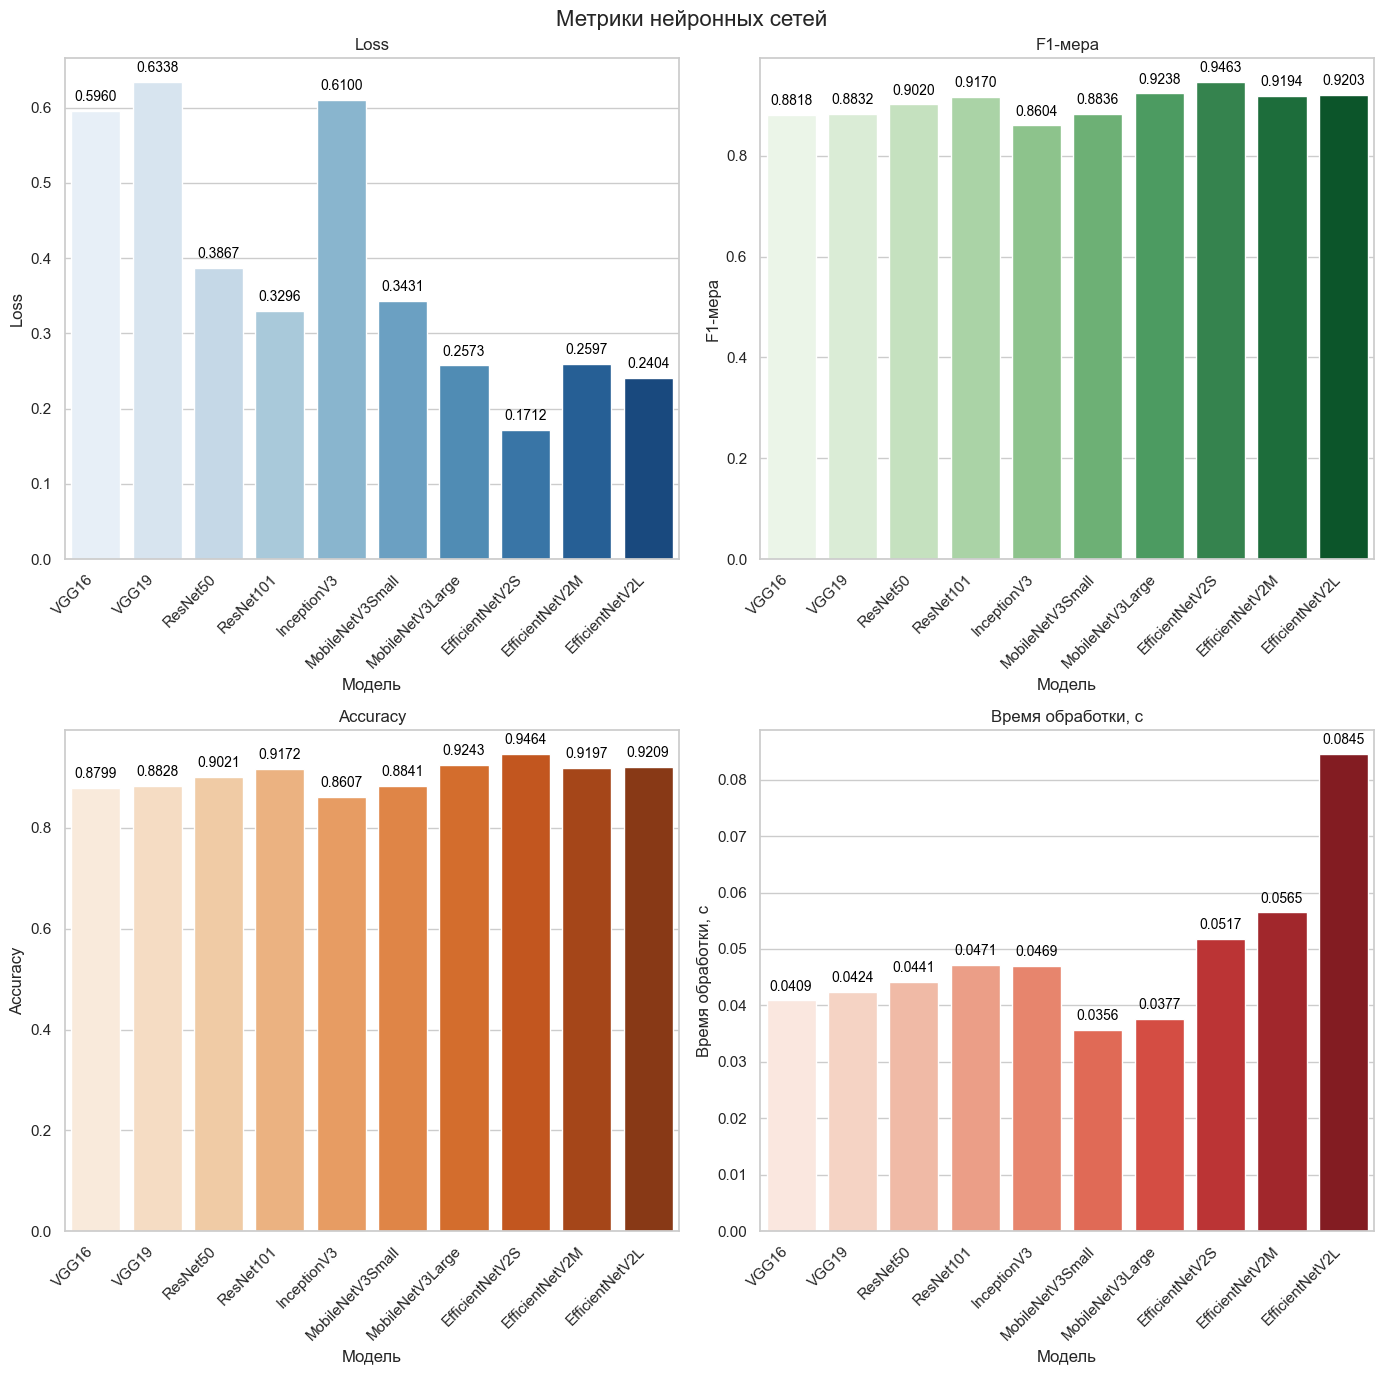

In [4]:
# Загрузка данных из CSV
filtered_data = pd.read_csv('evaluation_results.csv')

# Установка стиля графиков
sns.set(style="whitegrid")

# Настройка фигуры и размера подграфиков (2x2)
fig, axes = plt.subplots(2, 2, figsize=(14, 14))
fig.suptitle(f'Метрики нейронных сетей', fontsize=16)

# Функция для добавления значений над столбцами
def add_values(ax, metric):
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.4f}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='bottom', 
                    fontsize=10, color='black', xytext=(0, 5), 
                    textcoords='offset points')

# График для Loss
sns.barplot(x='Model', y='Loss', hue='Model', data=filtered_data, ax=axes[0, 0], palette="Blues", dodge=False)
axes[0, 0].set_title('Loss')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_xlabel('Модель')
add_values(axes[0, 0], 'Loss')


# График для F1 Score
sns.barplot(x='Model', y='F1 Score', hue='Model', data=filtered_data, ax=axes[0, 1], palette="Greens", dodge=False)
axes[0, 1].set_title('F1-мера')
axes[0, 1].set_ylabel('F1-мера')
axes[0, 1].set_xlabel('Модель')
add_values(axes[0, 1], 'F1 Score')


# График для Accuracy
sns.barplot(x='Model', y='Accuracy', hue='Model', data=filtered_data, ax=axes[1, 0], palette="Oranges", dodge=False)
axes[1, 0].set_title('Accuracy')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].set_xlabel('Модель')
add_values(axes[1, 0], 'Accuracy')


# График для Inference Time
sns.barplot(x='Model', y='Avg Inference Time (s)', hue='Model', data=filtered_data, ax=axes[1, 1], palette="Reds", dodge=False)
axes[1, 1].set_title('Время обработки, с')
axes[1, 1].set_ylabel('Время обработки, с')
axes[1, 1].set_xlabel('Модель')
add_values(axes[1, 1], 'Avg Inference Time (s)')


# Поворот меток оси x для всех графиков и настройка отображения
for ax in axes.flat:
    ax.set_xticks(range(len(filtered_data['Model'])))
    ax.set_xticklabels(filtered_data['Model'], rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Интерфейс

In [4]:
train_generator_default.class_indices

{'A-10': 0,
 'A-26': 1,
 'B-1': 2,
 'B-2': 3,
 'B-29': 4,
 'B-52': 5,
 'Boeing': 6,
 'C-130': 7,
 'C-135': 8,
 'C-17': 9,
 'C-21': 10,
 'C-5': 11,
 'E-3': 12,
 'F-16': 13,
 'F-22': 14,
 'KC-10': 15,
 'P-63': 16,
 'T-43': 17,
 'T-6': 18,
 'U-2': 19}

In [1]:
%gui qt


In [4]:
import sys
import os
import numpy as np

# Импорт необходимых классов из PyQt5 для создания графического интерфейса
from PyQt5.QtWidgets import (
    QApplication, QMainWindow, QWidget, QVBoxLayout, QPushButton,
    QLabel, QFileDialog, QSizePolicy
)
from PyQt5.QtGui import QPixmap, QImage, QFont, QIcon
from PyQt5.QtCore import Qt

# Импорт библиотек для работы с моделью Keras и обработки изображений
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from PIL import Image

# Задаём целевой размер изображения для модели
TARGET_SIZE = (200, 200)

# Пути к файлам модели и иконки
MODEL_PATH = "Result_models/EfficientNetV2S_best_model.h5"
ICON_PATH = "icon.svg"

# Проверка, что файлы модели и иконки существуют
if not all(os.path.exists(p) for p in [MODEL_PATH, ICON_PATH]):
    raise FileNotFoundError("Проверьте пути к файлам модели и иконки!")

# Загрузка обученной модели Keras
model = load_model(MODEL_PATH)

# Список классов для классификации
CLASSES = [
    'A-10', 'A-26', 'B-1', 'B-2', 'B-29', 'B-52', 'Boeing',
    'C-130', 'C-135', 'C-17', 'C-21', 'C-5', 'E-3', 'F-16',
    'F-22', 'KC-10', 'P-63', 'T-43', 'T-6', 'U-2'
]

class MainWindow(QMainWindow):
    """Основное окно приложения для классификации самолётов по спутниковым снимкам."""
    
    def __init__(self):
        super().__init__()
        # Установка заголовка окна
        self.setWindowTitle("Классификатор самолётов по спутниковым снимкам")
        # Установка минимального размера окна
        self.setMinimumSize(600, 500)
        # Установка иконки окна
        self.setWindowIcon(QIcon(ICON_PATH))
        
        # Переменная для хранения оригинального изображения (как QPixmap)
        self.original_pixmap = None
        
        # Создаём центральный виджет и устанавливаем вертикальный layout
        # Главное окно не может напрямую содержать элементы управления без центрального виджета
        self.central_widget = QWidget()
        self.setCentralWidget(self.central_widget)
        self.layout = QVBoxLayout(self.central_widget)
        
        # Создаём QLabel для отображения изображения
        self.image_label = QLabel()
        self.image_label.setAlignment(Qt.AlignCenter)
        # Разрешаем виджету расширяться при изменении размера окна
        self.image_label.setSizePolicy(QSizePolicy.Expanding, QSizePolicy.Expanding)
        self.layout.addWidget(self.image_label)
        
        # Создаём кнопку для загрузки изображения
        self.btn_load = QPushButton("Загрузить изображение")
        self.btn_load.setFont(QFont("Arial", 14))
        # Фиксированный размер для кнопки
        self.btn_load.setSizePolicy(QSizePolicy.Fixed, QSizePolicy.Fixed)
        # Подключаем сигнал нажатия к методу load_image
        self.btn_load.clicked.connect(self.load_image)
        self.layout.addWidget(self.btn_load, alignment=Qt.AlignCenter)
        
        # Создаём QLabel для вывода результата классификации
        self.result_label = QLabel("")
        self.result_label.setAlignment(Qt.AlignCenter)
        self.result_label.setFont(QFont("Arial", 16))
        self.layout.addWidget(self.result_label)
        
        # Устанавливаем стили для элементов интерфейса через CSS
        self.setStyleSheet("""
            QMainWindow { background-color: #f0f8ff; }
            QPushButton {
                background-color: #4682B4;
                color: white;
                padding: 10px 20px;
                border-radius: 10px;
            }
            QPushButton:hover { background-color: #5A9BD5; }
            QLabel { color: #333333; }
        """)

    def load_image(self):
        """
        Обработчик для загрузки изображения.
        Открывает диалог выбора файла, загружает изображение, отображает его,
        выполняет предобработку для модели, делает предсказание и выводит результат.
        """
        # Настройки диалога выбора файла
        options = QFileDialog.Options()
        file_path, _ = QFileDialog.getOpenFileName(
            self, "Выберите изображение", "",
            "Image Files (*.png *.jpg *.jpeg *.bmp);;All Files (*)", options=options
        )
        
        # Если файл не выбран, прерываем выполнение
        if not file_path:
            return

        # Загружаем изображение как QPixmap для отображения в интерфейсе
        self.original_pixmap = QPixmap(file_path)
        if self.original_pixmap.isNull():
            self.result_label.setText("Ошибка загрузки изображения.")
            return
        
        # Обновляем отображение изображения с учётом размеров виджета
        self.update_image_display()
        
        try:
            # Открываем изображение с помощью PIL, приводим его к формату RGB и меняем размер
            img = Image.open(file_path).convert('RGB').resize(TARGET_SIZE)
            # Преобразуем изображение в массив numpy
            img_array = image.img_to_array(img)
            # Делаем предсказание модели. np.expand_dims добавляет размерность для пакета изображений
            predictions = model.predict(np.expand_dims(img_array, axis=0))
            
            # Определяем индекс класса с наибольшей вероятностью
            predicted_idx = np.argmax(predictions[0])
            # Вычисляем уверенность в предсказании (в процентах)
            confidence = predictions[0][predicted_idx] * 100
            # Получаем название класса, если индекс корректен, иначе выдаём "Неизвестный класс"
            model_name = CLASSES[predicted_idx] if predicted_idx < len(CLASSES) else "Неизвестный класс"
            
            # Выводим результат классификации в QLabel
            self.result_label.setText(
                f"Результат: {model_name} ({confidence:.2f}% уверенности)"
            )
        except Exception as e:
            # При ошибке выводим её описание
            self.result_label.setText(f"Ошибка: {str(e)}")

    def update_image_display(self):
        """
        Обновление отображения изображения в QLabel с масштабированием по размеру окна.
        Используется оригинальное изображение (QPixmap) для корректного масштабирования.
        """
        if self.original_pixmap:
            # Масштабируем изображение с сохранением пропорций и сглаживанием
            scaled_pixmap = self.original_pixmap.scaled(
                self.image_label.width(),
                self.image_label.height(),
                Qt.KeepAspectRatio,
                Qt.SmoothTransformation
            )
            self.image_label.setPixmap(scaled_pixmap)

    def resizeEvent(self, event):
        """
        Обработчик события изменения размера окна.
        Обновляет отображение изображения, чтобы оно корректно подстраивалось под новый размер.
        """
        self.update_image_display()
        super().resizeEvent(event)

# Запуск приложения
if __name__ == '__main__':

    # Проверяем, существует ли уже экземпляр QApplication
    app = QApplication.instance()
    if not app:
        # Если экземпляра нет, создаём новый с аргументами командной строки
        app = QApplication(sys.argv)
    
    # Создаём и отображаем главное окно приложения
    window = MainWindow()
    window.show()
    
    sys.exit(app.exec_())


1/1 [==============================] - 1s 1s/step


SystemExit: 0